In [472]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import requests
from urllib.parse import urlparse, urlunparse, quote
from io import StringIO
from requests.packages.urllib3.exceptions import InsecureRequestWarning
from requests.packages.urllib3 import disable_warnings

%matplotlib inline

Загрузим данные о номинальной заработной плате по отраслям экономики

In [473]:
df_1 = pd.read_excel('https://rosstat.gov.ru/storage/mediabank/tab3-zpl_2023.xlsx', 
                     sheet_name=0, 
                     skiprows=5, 
                     names=['name', '2017', '2018', '2019', '2020', '2021', '2022', '2023'],
                     skipfooter=3,
                    index_col=0)

In [474]:
df_1 = df_1 \
    .dropna() \
    .rename(index={'деятельность гостиниц и предприятий общественного питания': 'гостиницы и рестораны'})

In [475]:
df_1.index = df_1.index.str.strip()

Оставим для анализа данные о заработной плате в следующих отраслях:
- гостиницы и рестораны
- добыча полезных ископаемых
- образование

In [476]:
df_1_main = df_1.loc[['гостиницы и рестораны', 'добыча полезных ископаемых', 'образование']]

In [477]:
df_2 = pd.read_excel('https://rosstat.gov.ru/storage/mediabank/tab3-zpl_2023.xlsx', 
                     sheet_name=1, 
                     skiprows=2, 
                     header=0,
                     skipfooter=2,
                    index_col=0)

In [478]:
df_2 = df_2.rename(columns={'Unnamed: 0': 'name'},
                  index={'Добыча полезных ископаемых': 'добыча полезных ископаемых',
                         'Гостиницы и рестораны': 'гостиницы и рестораны',
                         'Образование': 'образование'}) \
            .dropna()

In [479]:
df_2_main = df_2.loc[['добыча полезных ископаемых', 'гостиницы и рестораны', 'образование']]

In [480]:
df_main = df_2_main.merge(df_1_main, left_index=True, right_index=True)

In [481]:
df_main = df_main.T

In [482]:
df_main.index = df_main.index.astype(int)

<Axes: >

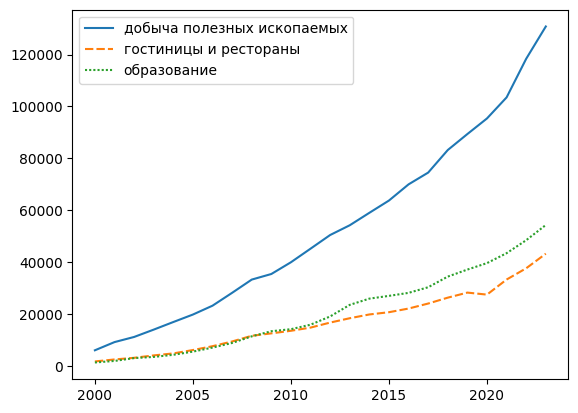

In [483]:
sns.lineplot(df_main)

In [484]:
df_main.describe()

,добыча полезных ископаемых,гостиницы и рестораны,образование
count,24.000000,24.000000,24.00000
mean,53067.995833,17000.362500,20829.77500
std,36175.305078,11589.331922,15930.73969
min,5940.200000,1640.000000,1240.20000
25%,22290.625000,7149.625000,6594.90000
50%,47766.300000,15661.800000,17402.20000
75%,76650.075000,24538.125000,31283.45000
max,130825.600000,43191.800000,54262.70000


<Axes: >

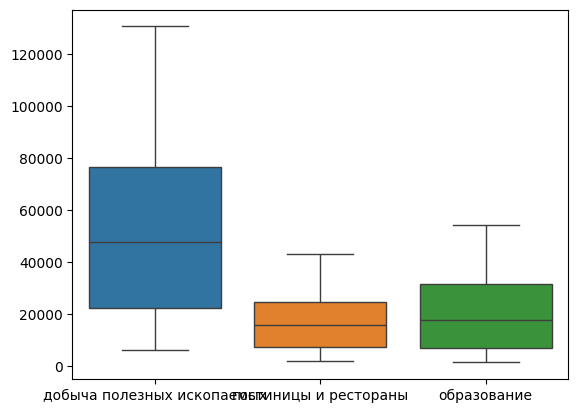

In [485]:
sns.boxplot(df_main)

Загрузим данные о инфляции по годам

In [486]:
def encode_punycode(url):
    # Разбиваем URL на компоненты
    parsed_url = urlparse(url)
    # Кодируем доменное имя в Punycode
    encoded_domain = parsed_url.hostname.encode('idna').decode('ascii')
    # Кодируем путь для безопасной передачи через URL
    encoded_path = quote(parsed_url.path)
    # Возвращаем перекодированный URL
    return urlunparse(parsed_url._replace(netloc=encoded_domain, path=encoded_path))

# Отключаем предупреждения SSL
disable_warnings(InsecureRequestWarning)

# Исходный URL
url = 'https://уровень-инфляции.рф/таблицы-инфляции'

# Кодирование доменного имени и пути в Punycode/URL-код
encoded_url = encode_punycode(url)
print("Encoded URL:", encoded_url)

# Пытаемся загрузить данные, игнорируя проверку SSL
try:
    response = requests.get(encoded_url, verify=False)
    # Использование StringIO для считывания HTML
    html_data = StringIO(response.text)
    tables = pd.read_html(html_data)  # Используем StringIO объект для pandas
    print(f"Найдено таблиц: {len(tables)}")
    if tables:
        df_inf = tables[0]
        # Опционально: сохранение таблиц в CSV
        for i, table in enumerate(tables):
            table.to_csv(f'table_{i+1}.csv', index=False)
        print("Таблицы сохранены в файлы CSV.")
    else:
        print("На странице не найдены таблицы.")
except Exception as e:
    print("Произошла ошибка при загрузке таблиц:", e)


Encoded URL: https://xn----ctbjnaatncev9av3a8f8b.xn--p1ai/%D1%82%D0%B0%D0%B1%D0%BB%D0%B8%D1%86%D1%8B-%D0%B8%D0%BD%D1%84%D0%BB%D1%8F%D1%86%D0%B8%D0%B8
Найдено таблиц: 2
Таблицы сохранены в файлы CSV.


In [487]:
df_inf = df_inf.set_index('Год') \
    .rename(columns={'Всего': 'inf_rate'})

In [488]:
df_inf = df_inf['inf_rate']

In [489]:
df_inf = df_inf.sort_index(ascending=True)

Добавим данные о инфляции в основную таблицу

In [490]:
df_main = df_main.merge(df_inf, how='left', left_index=True, right_index=True)

In [491]:
df_main.head()

,добыча полезных ископаемых,гостиницы и рестораны,образование,inf_rate
2000,5940.2,1640.0,1240.2,20.20
2001,9099.2,2403.6,1833.0,18.58
2002,11080.9,3039.3,2927.3,15.06
2003,13912.4,3966.7,3386.6,11.99
2004,16841.7,4737.3,4203.4,11.74


Рассчитаем реальную заработную плату по отраслям

In [492]:
df_main = df_main.assign(real_добыча_полезных_ископаемых = df_main[['добыча полезных ископаемых']].apply(lambda x: x / (1 + df_main['inf_rate'] / 100)).round(2), 
        real_гостиницы_и_рестораны = df_main[['гостиницы и рестораны']].apply(lambda x: x / (1 + df_main['inf_rate'] / 100)).round(2), 
        real_образование = df_main[['образование']].apply(lambda x: x / (1 + df_main['inf_rate'] / 100)).round(2))

In [493]:
df_main

,добыча полезных ископаемых,гостиницы и рестораны,образование,inf_rate,real_добыча_полезных_ископаемых,real_гостиницы_и_рестораны,real_образование
2000,5940.2,1640.0,1240.2,20.20,4941.93,1364.39,1031.78
2001,9099.2,2403.6,1833.0,18.58,7673.47,2026.99,1545.79
2002,11080.9,3039.3,2927.3,15.06,9630.54,2641.49,2544.15
2003,13912.4,3966.7,3386.6,11.99,12422.89,3542.01,3024.02
2004,16841.7,4737.3,4203.4,11.74,15072.22,4239.57,3761.77
2005,19726.9,6033.4,5429.7,10.91,17786.40,5439.91,4895.59
2006,23145.2,7521.7,6983.3,9.00,21234.13,6900.64,6406.70
2007,28107.5,9339.0,8778.3,11.87,25125.15,8348.08,7846.88
2008,33206.1,11536.2,11316.8,13.28,29313.29,10183.79,9990.11
2009,35363.4,12469.6,13293.6,8.80,32503.12,11461.03,12218.38


Построим графики номинальной и реальной заработной платы по отраслям

Text(0.5, 0.98, 'Динамика номинальной и реальной заработной платы по отраслям')

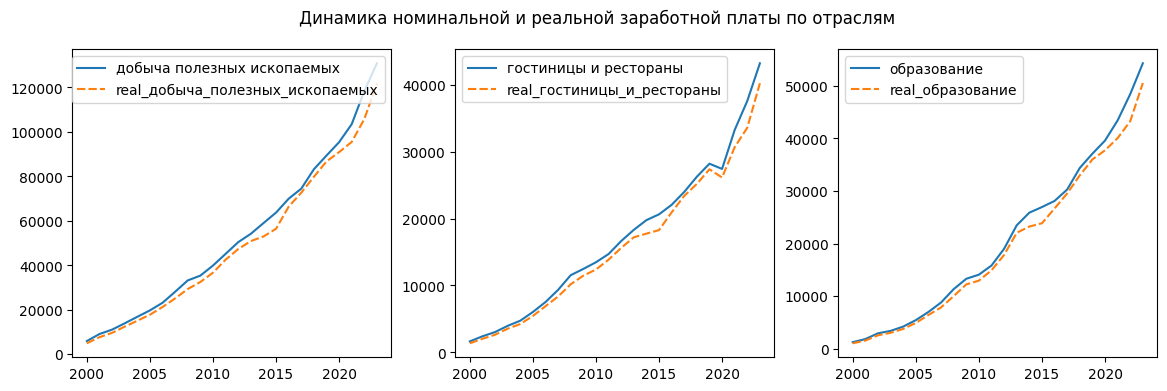

In [494]:
plt.figure(figsize=(14, 4))
plt.subplot(131)
sns.lineplot(data = df_main[['добыча полезных ископаемых', 'real_добыча_полезных_ископаемых']])
plt.subplot(132)
sns.lineplot(data = df_main[['гостиницы и рестораны', 'real_гостиницы_и_рестораны']])
plt.subplot(133)
sns.lineplot(data = df_main[['образование', 'real_образование']])
plt.suptitle('Динамика номинальной и реальной заработной платы по отраслям')

Посчитаем темп роста в % год к году

In [495]:
df_growth = df_main.pct_change().mul(100).round(2).reset_index()

In [496]:
df_growth

,index,добыча полезных ископаемых,гостиницы и рестораны,образование,inf_rate,real_добыча_полезных_ископаемых,real_гостиницы_и_рестораны,real_образование
0,2000,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2001,53.18,46.56,47.80,-8.02,55.27,48.56,49.82
2,2002,21.78,26.45,59.70,-18.95,25.50,30.32,64.59
3,2003,25.55,30.51,15.69,-20.39,28.99,34.09,18.86
4,2004,21.06,19.43,24.12,-2.09,21.33,19.69,24.40
5,2005,17.13,27.36,29.17,-7.07,18.01,28.31,30.14
6,2006,17.33,24.67,28.61,-17.51,19.38,26.85,30.87
7,2007,21.44,24.16,25.70,31.89,18.32,20.98,22.48
8,2008,18.14,23.53,28.92,11.88,16.67,21.99,27.31
9,2009,6.50,8.09,17.47,-33.73,10.88,12.54,22.30
